# Get the Data

In [1]:
import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)

    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# a quick look into the Data Structure

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#### Observation:
There are 20640 instances in the dataset but the 'total_bedrooms' attribute has only 20433 non-null values, meaning 207 districts are missing this feature.
All numerical values except the 'ocean_proximity' field. Its type is object, so it could hold ay kind of python object, but since the data is loaded from a CSV file, we know it must be a text attribute.

Let's see what values or categories exists in 'ocean_proximity' column and how many instances(i.e. districts in this case) belong to each category by using the value_counts() method:

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Similarly, the describe() method will show us a summary of the numerical attributes:

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


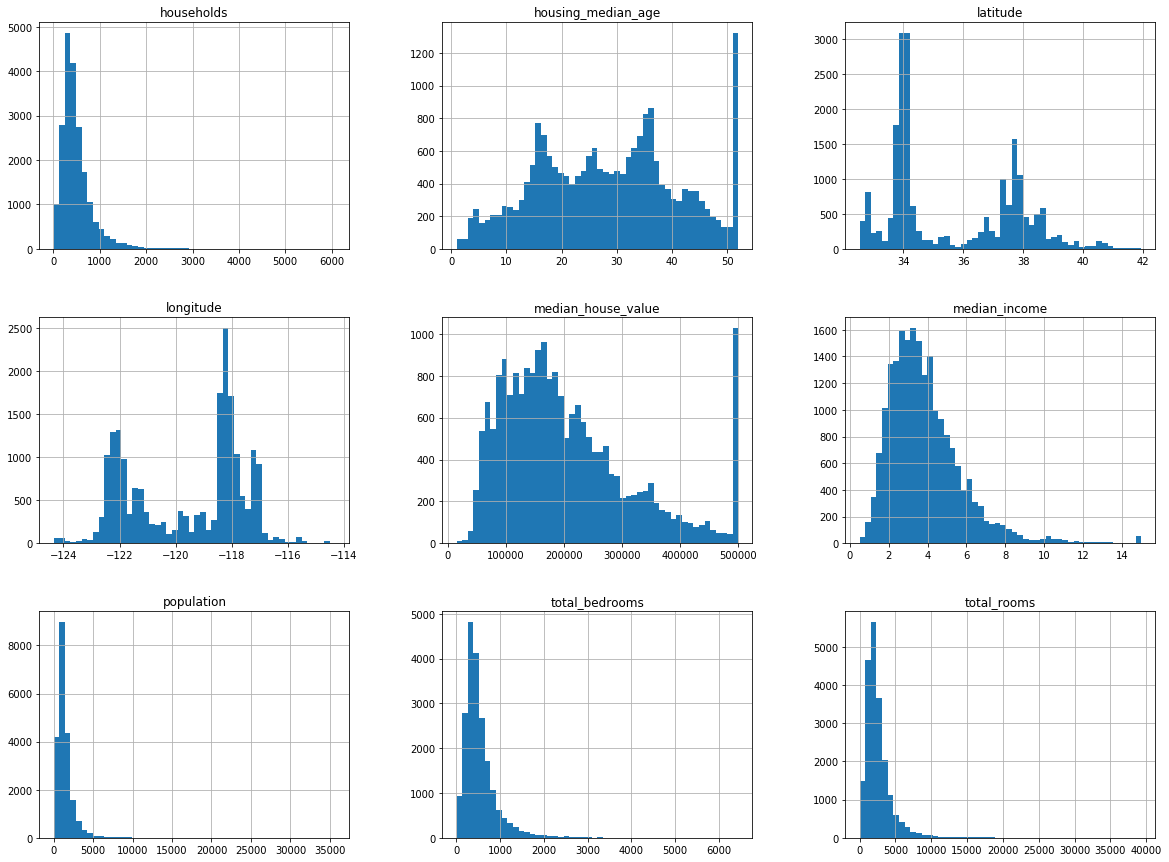

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

## a little intro to Stratified Sampling:
When a survey company decides to call 1000 people to ask them a few questions, they don't just pick 1000 people randomly. They try to ensure that these 1000 people are representative of the whole population. For example, say a country's population is composed of 53.3% male and 46.7% female, so a well-conducted survey in that country would try to maintainthis ratio in the sample: 533 male and 467 female. This is called 'Stratified Sampling': the population is divided into homogeneous subgroups called 'strata', and the right number of instances is sampled from each strata to guarantee that the test-set is representative of the overall population.


Assuming that the median_income is a very important attribute to predicting the median_house_value (which is our label). We therefore, need to ensure that test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, we first need to create an income category attribute. Its important to have a significant number of instances in the dataset for each stratum, or else the estimate of the stratum's importance may be biased. This means that we can't afford to have too many strata, and each strata should be large enough.

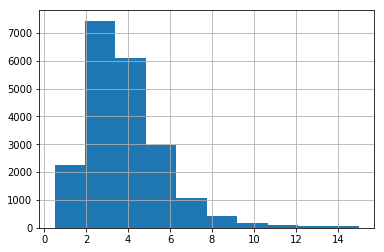

In [9]:
housing["median_income"].hist()

creating an income category attribute by dividing the median_income by 1.5 (just to limit the number of income categories), and rounding up using ceil function (to have proper discrete categories), and then merging all the categories greater than 5 into category 5.

In [10]:
# Dividing by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Labelling those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, other=5.0, inplace=True)

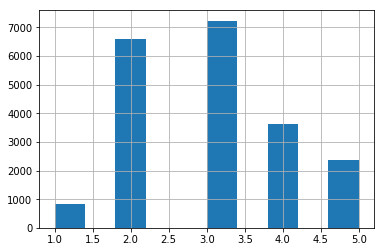

In [11]:
housing["income_cat"].hist()

Now we're ready to do the stratified sampling based on income category. 

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Lets see if this worked as expected. by looking at the income category proportions in the full housing dataset.

In [13]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Now lets measure the income category proportions in the test set and see if this is in same proportion as in case of whole dataset.

In [14]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

#### Observation:
the test set generated using stratified sampling has income category proportions almost identical to those in the whole dataset. Now the important question that arises why in particular go for stratified sampling and not random-sampling????

##### Answer:

In [15]:
# generating train and test sets using random rampling
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


As we can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using random sampling is quite skewed.

We'll now remove the income_cat attribute so that the data is back to its original state.

In [17]:
for item_set in (strat_train_set, strat_test_set):
    item_set.drop("income_cat", axis=1, inplace=True)

## Visualizing the data to Gain Insights

In [18]:
housing = strat_train_set.copy()

since there's geographical information(longitudes and latitudes), creating a scatter plot of all districts to visualize the data.

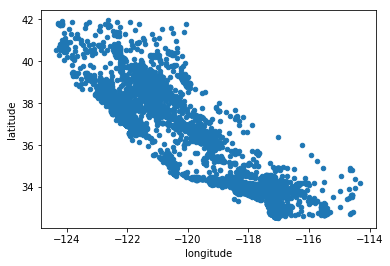

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude")

a very bad visualisation!

Setting alpha=0.1 to make it easier to visualize the places where there's a high density of data points.

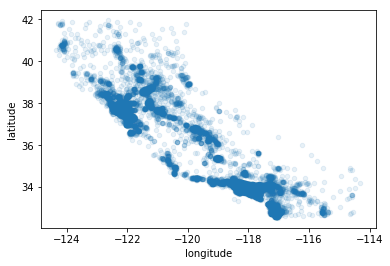

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

a much better visualisation!

plotting the districts's populations with the radius of circles (option s) and the housing prices with the colors (option c) using the predefined option of color map (cmap) called jet, which ranges from blue(low values) to red(high values)

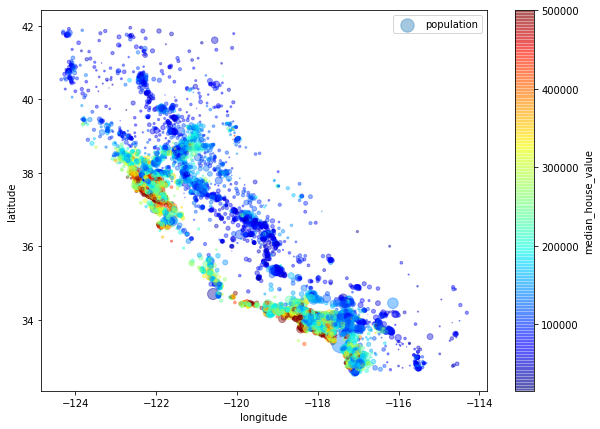

In [21]:
housing.plot(kind="scatter",x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            sharex=False)
plt.legend()

Lets plot this across an actual map of California and set its extent to the min and max values of "longitude" and, min and max values of "latitude"

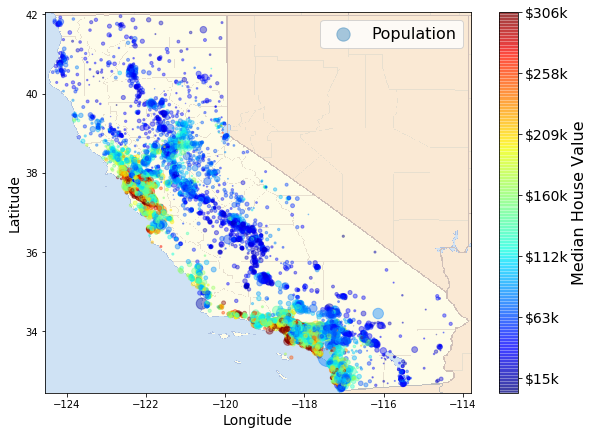

In [22]:
PROJECT_ROOT_DIR = "."
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

### Looking for Correlations

In [23]:
# since dataset is not too large, computing standard correlation coefficient (also called  Pearson's r) 
# between every pair of attributes using the corr() method
corr_matrix = housing.corr()

lets look at how much each attribute correlates with the median_house_value:

In [24]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

#### Observations:
The correlation coefficient ranges from -1 to 1. Values close to 1 means there's a strong positive correlation, values close to -1 means there's strong negative correlation and values close to zero means that there is no linear correlation.
Hence from the above values its quite clear that the median house values tend to go up when the median income goes up (positive correlation) and the median house value(i.e. the prices) have slight tendency to go down as you go North along the latitude (negative correlation). 

Another way to check the correlation between attributes is to use Pandas' scatter_matrix function, which plots every numerical attribute against every other numerical attributes. Since there are 11 numerical attributes, we'd get 11^2 = 121 plots, which would not fit this page, so lets just focus on a few promising attributes that seem most correlated with the median house value from the above calculation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000B940287198>,
      dtype=object)

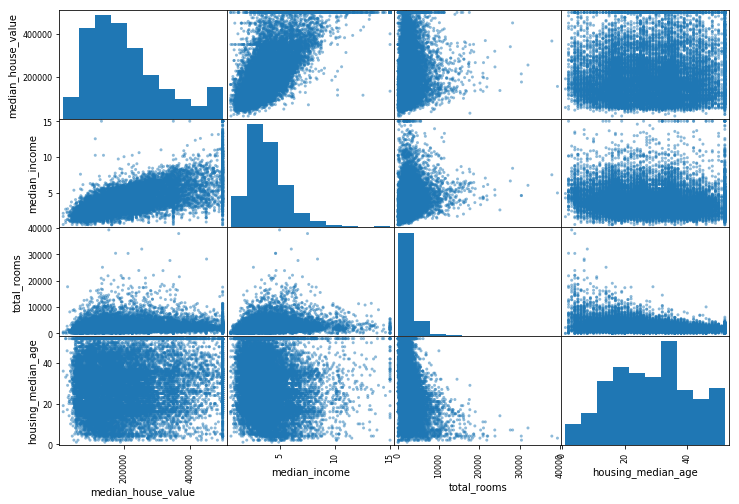

In [25]:
from pandas.plotting import scatter_matrix

imp_attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]

scatter_matrix(housing[imp_attributes], figsize=(12,8))

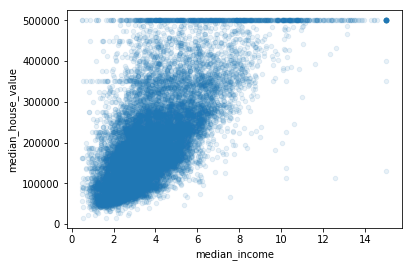

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

[0, 16, 0, 550000]

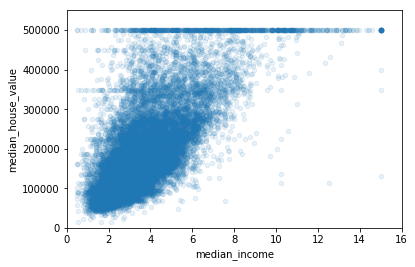

In [27]:
# extending the axis of the plot, and replotting the scatter plot just to be sure that i'm not missing any outlier
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])

### Experimenting with Attribute Combinations

In [28]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Now lets look at the correlation matrix again:

In [29]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Not bad!
#### Observations: 
the new 'bedrooms_per_room attribute is much more correlated with the median house value than the total no. of rooms or bedrooms. Also the houses with lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in district - obviously the larger the house, the more expensive they are.

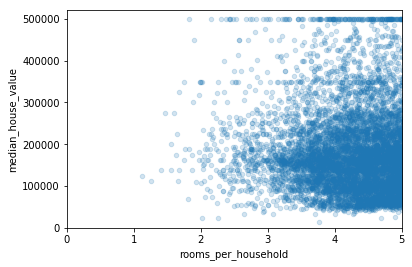

In [30]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [31]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


## Preparing Data for ML algorithms

Lets revert to a clean training set (by copying strat_train_set once again), and lets separate the predictors and the labels since we don't necessarily want to apply the same transformations to the predictors and the target values.

In [32]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Data Cleaning:
we know the total_bedrooms attribute ahs some missing values, in order to fix this we can either:

...get rid of the corresponding districts.

...get rid of the the whole attribute.

...or set the value to some values(zero, the mean, the median, etc)

In [33]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [34]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


##### Scikit-Learn also provides a handy class to take care of missing values: 'Imputer'

In [35]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity:

In [36]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [37]:
# fitting the imputer instance to training data using the fit() method
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

the Imputer simply computes the median of each attribute and stores the result in its 'statistics_' instance variable

In [38]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [39]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [40]:
# using this trained imputer to transform the training set by replacing the missing values by the learned medians:
X = imputer.transform(housing_num)

In [41]:
# the result is a Numpy Array hence putting it back to a dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [42]:
housing_tr[housing_tr.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


In [43]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


#### Handling Text and Categorical Attributes:

In [44]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

We'll use Pandas' factorize() method to convert this string categorical feature to an integer categorical feature, which will be easier for Machine Learning algorithms to handle:

In [45]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [46]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

We can convert each categorical value to a one-hot vector using a OneHotEncoder:

In [47]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(1,-1))
housing_cat_1hot

<1x16512 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

NOTE: note that fit_transform() expects a 2D array, but housing_cat_encoded is a 1D array, so we needed to reshape it. The Numpy's reshape() function allows one dimension to be -1, which mean "unspecified": the value is inferred from the length of the array and the remaining dimensions

In [48]:
# The OneHotEncoder returns a sparse array by default, but we can convert it to a dense array if needed:
housing_cat_1hot.toarray()

array([[1., 1., 1., ..., 1., 1., 1.]])

#### Custom Transformers

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

#column indexes
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:,rooms_ix] / X[:,household_ix]
        population_per_household = X[:,population_ix] / X[:,household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [50]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household",
                                                                                           "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


#### Building a pipeline for preprocessing the numerical attributes

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [52]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

##### and a transformer to just select a subset of the Pandas DataFrame columns:

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

# Creating a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names].values

#### Complete Pipeline:
Now joining all these components into a big pipeline that will preprocess both the numerical and the categorical features

In [54]:
from sklearn.preprocessing import CategoricalEncoder

num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense"))
])

ImportError: cannot import name 'CategoricalEncoder'

In [55]:
# categoricalEncoder not available witht he current release. [See PR #9151].
# Definition of the CategoricalEncoder class, copied from Pull-Request #9151.
# Just copy-pasting the code from there, not really required but will try to understand it later(not now!).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [56]:
num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense"))
])

Now coming back to the part where we join these pipelines into a big pipeline for preprocessing both numerical and categorical attributes

In [57]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

Now running the whole pipeline simply

In [58]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Selecting and Training a Model
So far, we've framed the problem, got the data and explored it, sampled a training set and a test set, wrote a trasformation pipeline to clean up and prepare the data for Machine Learning algorithms automatically. Now to select and train a ML model.

In [59]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [60]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


comparing against the actual values:

In [61]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


not exactly accurate!
Let's measure the regression model's RMSE on the whole training set 

In [62]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

most district's median_housing_values range between 120,000 (i.e. 25th quadrant) and 265,000 (i.e. 75th quadrant), so there's a typical prediction error of $ 68,628 in the median_housing_values.

A clear case of model underfitting the training data. This means either the features do not provide enough information to make good predictions, or that the model is not powerful enough. The main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. As this model is not regularized, this rules out the last option.

In [63]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [64]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

#### Cross-Validation:

In [65]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

scikit-learn cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of MSE (i.e. a negative value), which is why the preceding code computes -scores before calculating the square root.

In [66]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [68144.63480675 67383.32286469 70334.2508882  69348.66160861
 71327.93697183 73947.263267   71390.98422681 71217.06959784
 76891.64164654 70064.55852654]
Mean: 71005.03244048063
Standard deviation: 2626.4754774424796


this is even worse than Linear Regression model! The Decision Tree has a score of approximately 70,960, generally ±2525. Lets compute the scores for the Linear Regression model as well just to be sure.

In [67]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983425


hence, its clear the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

In [68]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [69]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [70]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51650.94405471 48920.80645498 52979.16096752 54412.74042021
 50861.29381163 56488.55699727 51866.90120786 49752.24599537
 55399.50713191 53309.74548294]
Mean: 52564.19025244012
Standard deviation: 2301.873803919754


this is much better! Random Forest looks very promising. However the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set.

### Fine-Tunning the Model:

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # trying 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then trying 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error")

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

the best combination of hyperparameters can be found as:

In [72]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

we can also get the best estimator directly as:

In [73]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [74]:
cv_res = grid_search.cv_results_

#cv_res
for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(np.sqrt(-mean_score), params)

63703.49772249533 {'n_estimators': 3, 'max_features': 2}
55833.329291492286 {'n_estimators': 10, 'max_features': 2}
53055.574605842776 {'n_estimators': 30, 'max_features': 2}
60686.87850685311 {'n_estimators': 3, 'max_features': 4}
52659.177298610935 {'n_estimators': 10, 'max_features': 4}
50436.341873073594 {'n_estimators': 30, 'max_features': 4}
58429.23609112605 {'n_estimators': 3, 'max_features': 6}
52322.28861605348 {'n_estimators': 10, 'max_features': 6}
49879.26045291737 {'n_estimators': 30, 'max_features': 6}
59547.32900009518 {'n_estimators': 3, 'max_features': 8}
51602.6849717 {'n_estimators': 10, 'max_features': 8}
49876.38825982574 {'n_estimators': 30, 'max_features': 8}
62355.53517926551 {'bootstrap': False, 'n_estimators': 3, 'max_features': 2}
54527.08410143822 {'bootstrap': False, 'n_estimators': 10, 'max_features': 2}
58418.64244374245 {'bootstrap': False, 'n_estimators': 3, 'max_features': 3}
52033.12815989855 {'bootstrap': False, 'n_estimators': 10, 'max_features': 3

In [75]:
pd.DataFrame(grid_search.cv_results_)

D:\My_Work\PyCharm\venvs\california-housing-venv\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\My_Work\PyCharm\venvs\california-housing-venv\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\My_Work\PyCharm\venvs\california-housing-venv\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.078655,0.004208,-4.058136e+09,-1.096872e+09,NaN,2,3,"{'n_estimators': 3, 'max_features': 2}",18,-4.052592e+09,...,-4.027706e+09,-1.061102e+09,-3.727098e+09,-1.093071e+09,-4.354844e+09,-1.146403e+09,0.004927,3.981622e-04,2.017401e+08,2.890363e+07
1,0.279997,0.014003,-3.117361e+09,-5.723547e+08,NaN,2,10,"{'n_estimators': 10, 'max_features': 2}",11,-2.870639e+09,...,-3.089889e+09,-5.500533e+08,-2.990604e+09,-5.726913e+08,-3.215328e+09,-5.905034e+08,0.025530,2.096723e-03,1.892639e+08,1.341890e+07
2,0.765547,0.034428,-2.814894e+09,-4.307292e+08,NaN,2,30,"{'n_estimators': 30, 'max_features': 2}",9,-2.577956e+09,...,-2.893845e+09,-4.236101e+08,-2.666542e+09,-4.406899e+08,-3.032879e+09,-4.292548e+08,0.016920,8.143979e-04,1.671621e+08,6.310658e+06
3,0.124693,0.004599,-3.682897e+09,-9.594702e+08,NaN,4,3,"{'n_estimators': 3, 'max_features': 4}",16,-3.643367e+09,...,-3.810675e+09,-9.023351e+08,-3.436321e+09,-9.117531e+08,-3.719903e+09,-1.008047e+09,0.001014,4.871577e-04,1.376704e+08,4.408000e+07
4,0.403892,0.012813,-2.772989e+09,-5.223837e+08,NaN,4,10,"{'n_estimators': 10, 'max_features': 4}",8,-2.678486e+09,...,-2.861178e+09,-5.219101e+08,-2.550529e+09,-5.050118e+08,-2.975631e+09,-5.214058e+08,0.011464,7.552016e-04,1.469247e+08,1.046929e+07
5,1.201859,0.033817,-2.543825e+09,-3.924729e+08,NaN,4,30,"{'n_estimators': 30, 'max_features': 4}",3,-2.449188e+09,...,-2.657703e+09,-3.791444e+08,-2.376435e+09,-3.914669e+08,-2.658633e+09,-3.911606e+08,0.007560,1.161914e-03,1.133425e+08,1.137872e+07
6,0.167519,0.004204,-3.413976e+09,-9.143312e+08,NaN,6,3,"{'n_estimators': 3, 'max_features': 6}",14,-3.287890e+09,...,-3.485870e+09,-8.587272e+08,-3.180937e+09,-9.036706e+08,-3.548034e+09,-9.530125e+08,0.002581,4.009248e-04,1.528411e+08,4.028065e+07
7,0.565797,0.013205,-2.737622e+09,-5.153349e+08,NaN,6,10,"{'n_estimators': 10, 'max_features': 6}",7,-2.657359e+09,...,-2.824546e+09,-4.928616e+08,-2.563127e+09,-5.135662e+08,-2.860078e+09,-5.213999e+08,0.006185,1.167448e-03,1.109027e+08,1.346382e+07
8,1.992213,0.039829,-2.487941e+09,-3.811101e+08,NaN,6,30,"{'n_estimators': 30, 'max_features': 6}",2,-2.362618e+09,...,-2.603517e+09,-3.736420e+08,-2.317165e+09,-3.733276e+08,-2.630321e+09,-3.862237e+08,0.075106,2.317653e-03,1.264535e+08,6.510524e+06
9,0.261984,0.005008,-3.545884e+09,-9.269126e+08,NaN,8,3,"{'n_estimators': 3, 'max_features': 8}",15,-3.513231e+09,...,-3.510231e+09,-8.722889e+08,-3.340335e+09,-9.351724e+08,-3.691688e+09,-8.822043e+08,0.013974,7.888737e-06,1.282436e+08,4.541442e+07


In [76]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000B944F3C748>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000B944F3C518>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [77]:
cvres = rnd_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.15241724505 {'n_estimators': 180, 'max_features': 7}
51396.876896929905 {'n_estimators': 15, 'max_features': 5}
50797.05737322649 {'n_estimators': 72, 'max_features': 3}
50840.744513982805 {'n_estimators': 21, 'max_features': 5}
49276.17530332962 {'n_estimators': 122, 'max_features': 7}
50775.46331678437 {'n_estimators': 75, 'max_features': 3}
50681.383924974936 {'n_estimators': 88, 'max_features': 3}
49612.152530468346 {'n_estimators': 100, 'max_features': 5}
50473.01751424941 {'n_estimators': 150, 'max_features': 3}
64458.25385034794 {'n_estimators': 2, 'max_features': 5}


In [78]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.74816672e-02, 6.35400211e-02, 4.29150879e-02, 1.58796807e-02,
       1.42056625e-02, 1.48874004e-02, 1.58698814e-02, 3.48480364e-01,
       4.20105798e-02, 1.15956037e-01, 8.33083813e-02, 5.08276598e-03,
       1.64389301e-01, 1.76098414e-04, 1.70037347e-03, 4.11669692e-03])

In [79]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34848036449573255, 'median_income'),
 (0.16438930106573726, 'INLAND'),
 (0.11595603737979512, 'pop_per_hhold'),
 (0.08330838128996984, 'bedrooms_per_room'),
 (0.06748166720234552, 'longitude'),
 (0.06354002113597133, 'latitude'),
 (0.04291508789349649, 'housing_median_age'),
 (0.04201057979224411, 'rooms_per_hhold'),
 (0.015879680659284315, 'total_rooms'),
 (0.015869881405606, 'households'),
 (0.014887400355380675, 'population'),
 (0.014205662535702294, 'total_bedrooms'),
 (0.005082765982219521, '<1H OCEAN'),
 (0.0041166969216514665, 'NEAR OCEAN'),
 (0.0017003734713130802, 'NEAR BAY'),
 (0.00017609841355046638, 'ISLAND')]

In [80]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [81]:
final_rmse

48304.90942918668

#### A full pipeline with both preparation and prediction

In [82]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

#### Model persistence using joblib

In [83]:
my_model = full_pipeline_with_predictor

In [84]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

#### Example SciPy distributions for RandomizedSearchCV

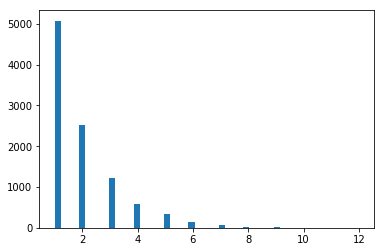

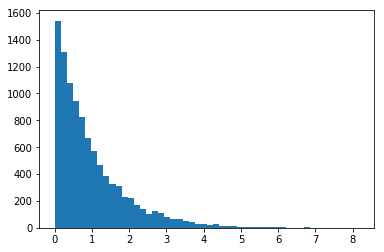

In [85]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()